In [1]:
import pandas as pd
import warnings
import sys
import matplotlib.pyplot as plt

from datetime import datetime
from monteCarloModel import MonteCarloModel

sys.path.insert(0, '..')

from utils import *

warnings.filterwarnings("ignore")

In [2]:
ticker = 'AAPL'
stock_data = fetch_stock_data(ticker)
expiry, calls, puts = fetch_options_data(ticker)
expiry = pd.to_datetime(expiry)
days_to_expiry = abs((expiry - datetime.now()).days)

# Calculate midpoint here to use for testing again lastPrice
calls['midpoint'] = (calls['bid'] + calls['ask']) / 2
puts['midpoint'] = (puts['bid'] + puts['ask']) / 2

[*********************100%***********************]  1 of 1 completed


In [3]:
# Calculate the monte carlo metrics
underlying_price = float(stock_data['Close'].iloc[-1])
years_to_expiry = float(days_to_expiry / 365)
risk_free_rate = float(fetch_risk_free_rate()) / 100
sigma = float(calculate_historical_volatility(stock_data))
dividend_yield = float(fetch_dividend_yield(ticker)) / 100

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Geometric Brownian Motion')

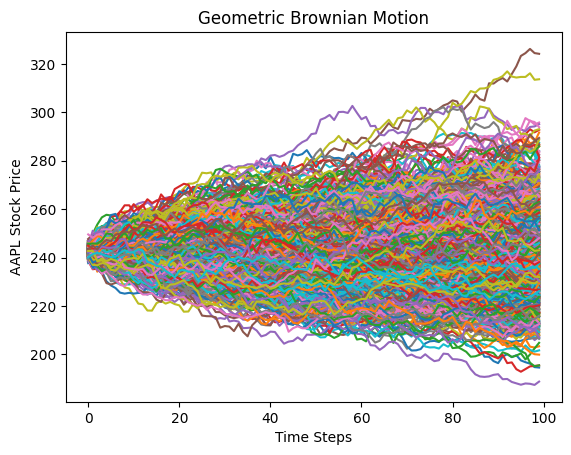

In [4]:
# Visulaize a monte carlo simulation for the first strike price
MCModel = MonteCarloModel(underlying_price, float(calls['strike'].iloc[1]), years_to_expiry, risk_free_rate, sigma, dividend_yield)
steps = 100 # time steps
Npaths = 1000 # number of trials
paths = MCModel.monte_carlo_model(Npaths, steps)

plt.plot(paths)
plt.xlabel("Time Steps")
plt.ylabel(f"{ticker} Stock Price")
plt.title("Geometric Brownian Motion")

In [5]:
# Create a pandas DataFrame to store the results
call_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])
put_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])

for strike, last_price in zip(calls['strike'], calls['midpoint']):
    call = MonteCarloModel(underlying_price, strike, years_to_expiry, risk_free_rate, sigma, dividend_yield)
    price = call.monte_carlo_call_option(Npaths, steps)
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": price,
        "Last Price (midpoint)": last_price,
        "Error": abs(price - last_price) / last_price
    })
    call_results = pd.concat([call_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_call_error = call_results[call_results['Error'] != 1]['Error'].mean()
print(f"Average Call Error: {((average_call_error)):.2f}%")

for strike, last_price in zip(puts['strike'], puts['midpoint']):
    put = MonteCarloModel(underlying_price, strike, years_to_expiry, risk_free_rate, sigma, dividend_yield)
    price = put.monte_carlo_put_option(Npaths, steps)
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": price,
        "Last Price (midpoint)": last_price,
        "Error": abs(price - last_price) / last_price
    })
    put_results = pd.concat([put_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_put_error = put_results[put_results['Error'] != 1]['Error'].mean()
print(f"Average Put Error: {((average_put_error)):.2f}%")

Average Call Error: 0.16%
Average Put Error: 0.29%


While Monte Carlo is a great way to price options, in order to derive accurate estimates we must perform a large number of simulations ```Npaths```. This is computationally inefficient. Instead, we can rely on **Variance Reduction Techniques** such as **Antithetic Variates** and **Control Variates** to improve precision without needing a massive increase in ```Npaths```. We could also apply **Quasi-Random Numbers** using Sobol sequences to improve convergence by spreading points more evenly across the sample space.

In [6]:
# Create a pandas DataFrame to store the results
call_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])
put_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])

for strike, last_price in zip(calls['strike'], calls['midpoint']):
    call = MonteCarloModel(underlying_price, strike, years_to_expiry, risk_free_rate, sigma, dividend_yield)
    price = call.monte_carlo_call_option(Npaths, steps, use_antithetic=True, use_control_variate=True, random_generator="quasi")
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": price,
        "Last Price (midpoint)": last_price,
        "Error": abs(price - last_price) / last_price
    })
    call_results = pd.concat([call_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_call_error = call_results[call_results['Error'] != 1]['Error'].mean()
print(f"Average Call Error: {((average_call_error)):.2f}%")

for strike, last_price in zip(puts['strike'], puts['midpoint']):
    put = MonteCarloModel(underlying_price, strike, years_to_expiry, risk_free_rate, sigma, dividend_yield)
    price = put.monte_carlo_put_option(Npaths, steps, use_antithetic=True, use_control_variate=True, random_generator="quasi")
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": price,
        "Last Price (midpoint)": last_price,
        "Error": abs(price - last_price) / last_price
    })
    put_results = pd.concat([put_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_put_error = put_results[put_results['Error'] != 1]['Error'].mean()
print(f"Average Put Error: {((average_put_error)):.2f}%")

Average Call Error: 0.32%
Average Put Error: 0.49%
